In [38]:
# !wget https://raw.githubusercontent.com/dasarpai/DAI-Projects/main/Telecom/Telecom-Churn/customer_data.csv

# !wget https://raw.githubusercontent.com/dasarpai/DAI-Projects/main/Telecom/Telecom-Churn/Telecom Churn Data Dictionary.csv

# !wget https://raw.githubusercontent.com/dasarpai/DAI-Projects/main/Telecom/Telecom-Churn/internet_data.csv

--2024-11-17 14:44:44--  https://raw.githubusercontent.com/dasarpai/DAI-Projects/main/Telecom/Telecom-Churn/customer_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181571 (177K) [text/plain]
Saving to: ‘customer_data.csv’

customer_data.csv   100%[===================>] 177.32K  --.-KB/s    in 0.005s  

2024-11-17 14:44:44 (38.4 MB/s) - ‘customer_data.csv’ saved [181571/181571]

--2024-11-17 14:44:44--  https://raw.githubusercontent.com/dasarpai/DAI-Projects/main/Telecom/Telecom-Churn/Telecom
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response

In [2]:
#Loading All Needed Libraries

In [3]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# #Number Manupulation & Plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# #Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

<font color=red size=6> Define Objective </font>

- Identify Hight Value Customer-HVC: Those who have recharged with an amount >= X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)

- Identify which customers are in action phase. 3rd month usage==0
- Identify which customers are churn. 3rd month + 4th month usage==0
- Make a model to predict churn from of HVC. But use only 3 month data.
- Compare the performance of model

1. It is a regression problem
- Make a model which has highest R-square score on test dataset.
- At the same time R-Score score on Train dataset should be such that it can be confidently accepted by the customer

<font color=red size=6> Understanding Dataset</font>

In [4]:
#A field will be treated as categorical if Max Categories are less than number below.
#This is just a guess and it can be tuned. It is just to ease the data cleaning process and has no other value.
max_cat=200

In [5]:
#Create a list of Categorical Variables. This step is useful when there are many fields in dataset
#If they are numeric in nature, convert into Object
#In final dataset all categorical variable (ordinal, nominal) will be object type

In [60]:
target_="Churn"
id_="mobile_number"

In [7]:
#Returns a list of field of particular type from dataset=df,
#fldType : cat for categorical variables, num for numerial variables
#the return list will not include target variable name and id variable name.

def get_fld_list(df, fldType, printResults=False):
    categories = min(max_cat, int(len(df)*.5))
    fld_list = []
    for col in df.columns:
        l=len(df[col].unique())
        if fldType=="cat":
            if l<=categories:
                fld_list.append(col)
                if printResults:
                    print ("Categorical Field:",col, df[col].unique())
            else:
                if printResults:
                    print ("Excluded Fields",col,l)
        elif fldType=="num":
            if l>categories:
                if l>categories:
                    fld_list.append(col)
                else:
                    if printResults:
                        print (col,l)

    if target_ in fld_list:
        fld_list.remove(target_)
    if id_ in fld_list:
        fld_list.remove(id_)

    return fld_list

<font color=red size=3>Understanding Field Name & Renaming them for correct standard use</font>

In [8]:
#Lad partial dataset in memory
df = pd.read_csv("churn_data.csv", index_col='customerID')

In [9]:
df

,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,
7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...
6840-RESVB,24,Yes,One year,Yes,Mailed check,84.80,1990.5,No
2234-XADUH,72,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
4801-JZAZL,11,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


In [10]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Display basic statistics
print(df.describe(include='all'))



             tenure PhoneService        Contract PaperlessBilling  \
count   7043.000000         7043            7043             7043   
unique          NaN            2               3                2   
top             NaN          Yes  Month-to-month              Yes   
freq            NaN         6361            3875             4171   
mean      32.371149          NaN             NaN              NaN   
std       24.559481          NaN             NaN              NaN   
min        0.000000          NaN             NaN              NaN   
25%        9.000000          NaN             NaN              NaN   
50%       29.000000          NaN             NaN              NaN   
75%       55.000000          NaN             NaN              NaN   
max       72.000000          NaN             NaN              NaN   

           PaymentMethod  MonthlyCharges  TotalCharges Churn  
count               7043     7043.000000   7032.000000  7043  
unique                 4             NaN     

In [11]:
# Check for missing values
print(df.isnull().sum())

tenure               0
PhoneService         0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [12]:
# prompt: can you takecare of totalcharges null values?

# Fill missing 'TotalCharges' values with the mean
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Alternatively, fill with median
# df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Verify that there are no more missing values in 'TotalCharges'
print(df.isnull().sum())

tenure              0
PhoneService        0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


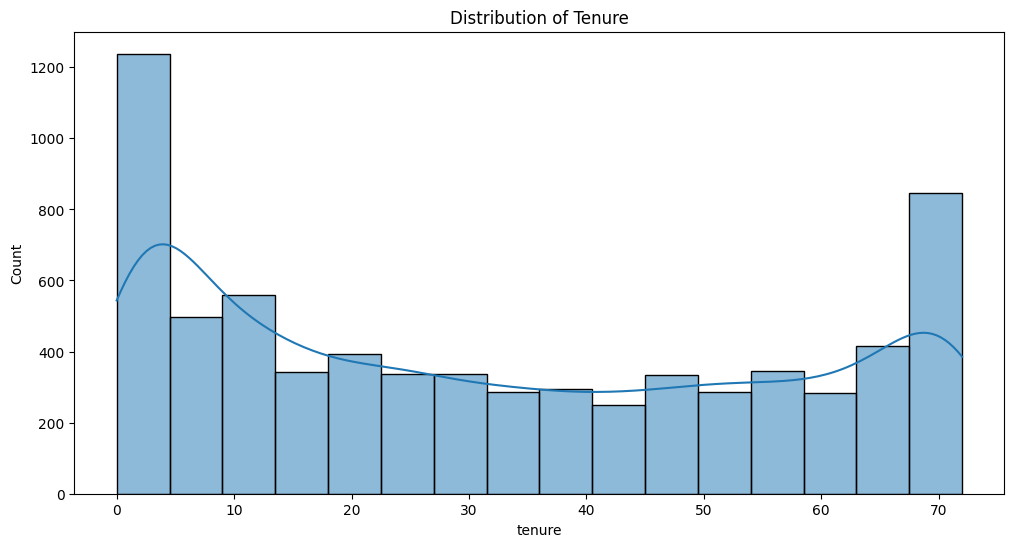

In [13]:
# Visualize distributions of numerical features
plt.figure(figsize=(12, 6))
sns.histplot(df['tenure'], kde=True)
plt.title('Distribution of Tenure')
plt.show()

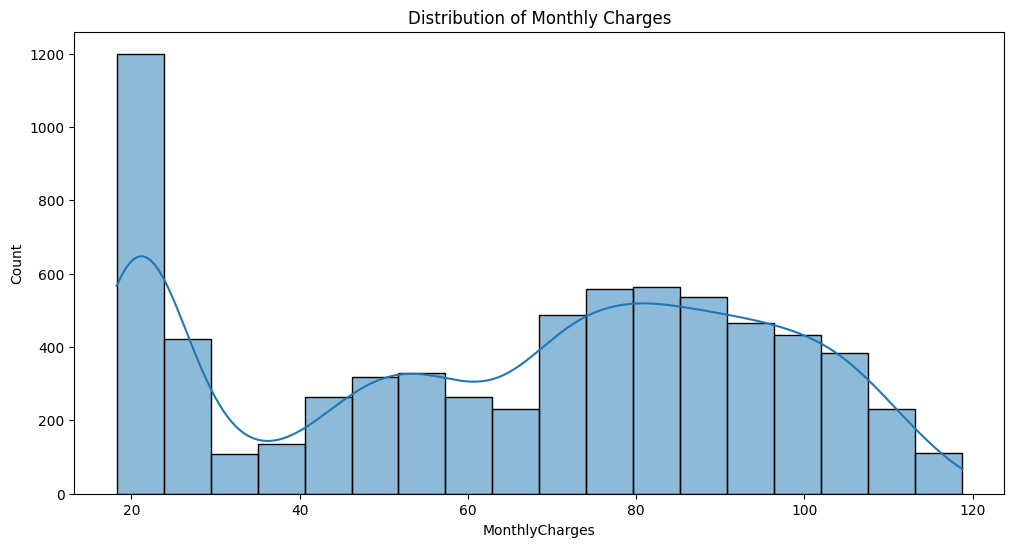

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(df['MonthlyCharges'], kde=True)
plt.title('Distribution of Monthly Charges')
plt.show()


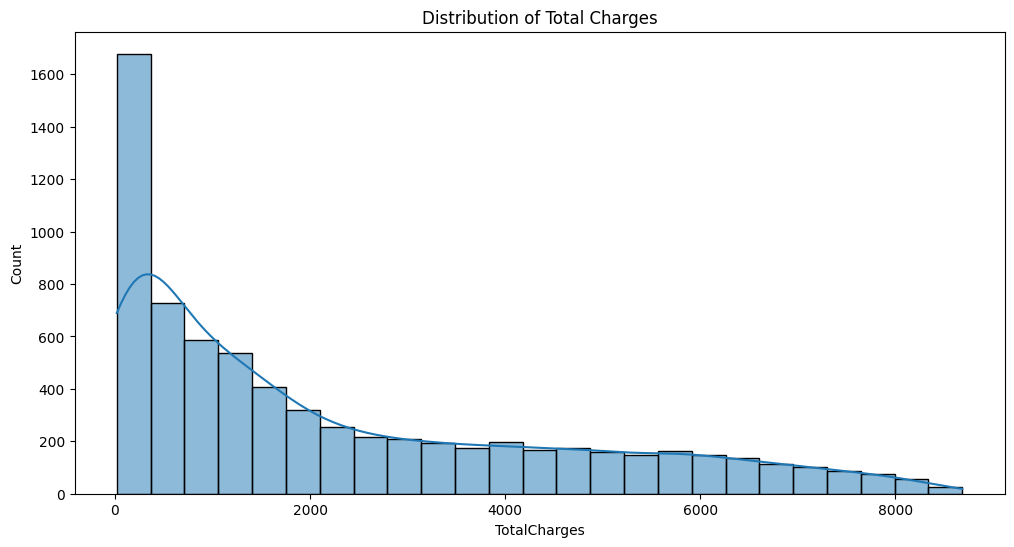

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(df['TotalCharges'], kde=True)
plt.title('Distribution of Total Charges')
plt.show()

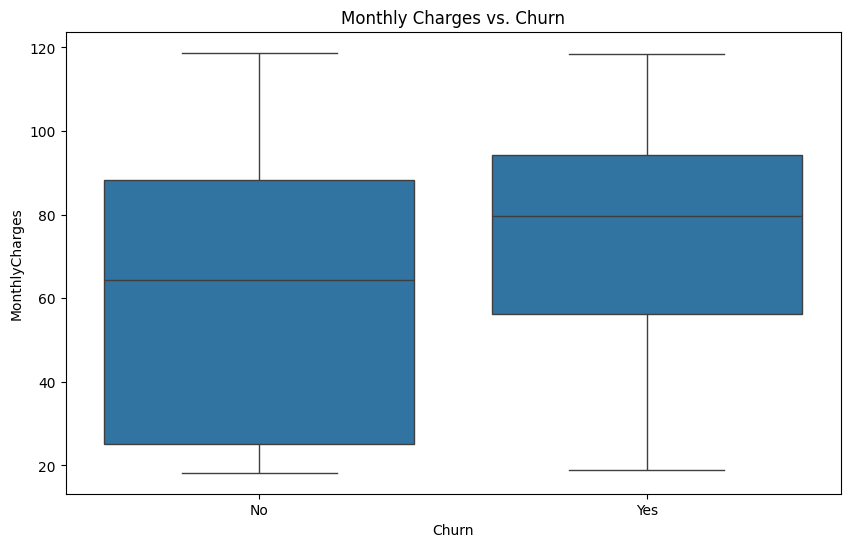

In [16]:

# Explore relationships between features
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs. Churn')
plt.show()


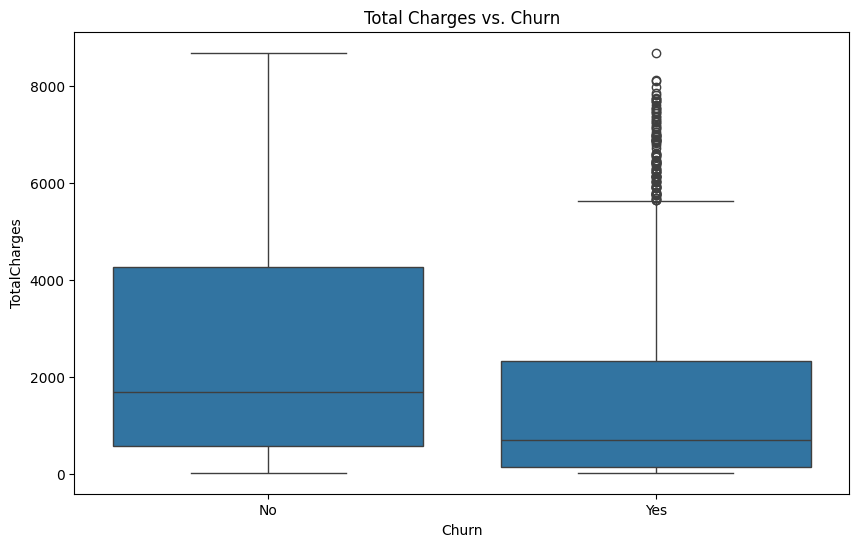

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.title('Total Charges vs. Churn')
plt.show()

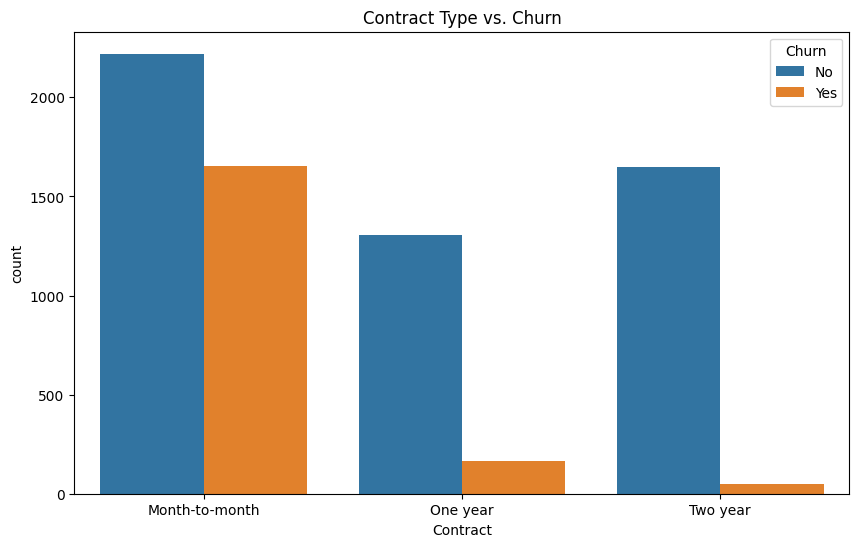

In [18]:
# Analyze categorical features
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Contract Type vs. Churn')
plt.show()

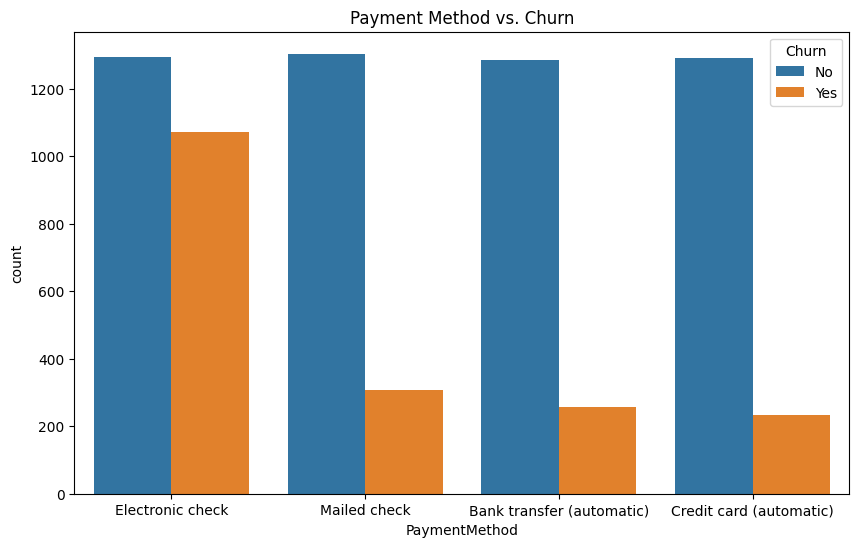

In [19]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Payment Method vs. Churn')
plt.show()


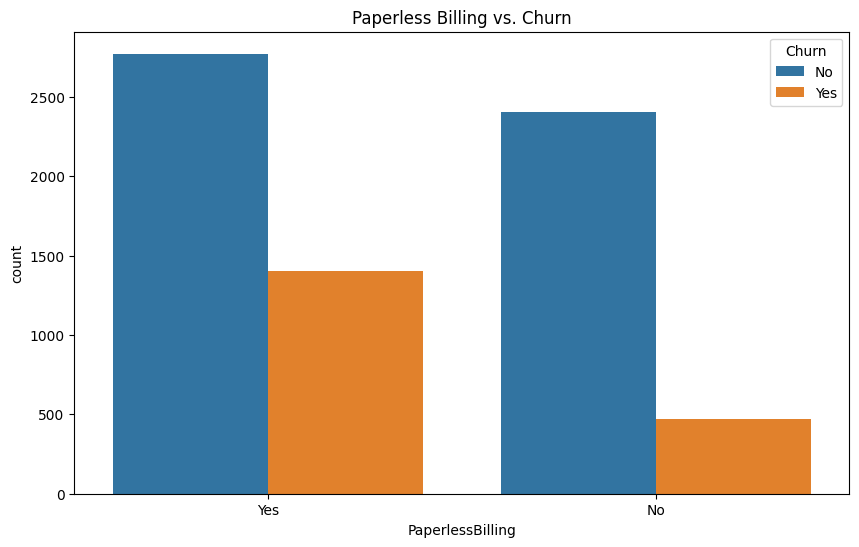

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PaperlessBilling', hue='Churn', data=df)
plt.title('Paperless Billing vs. Churn')
plt.show()

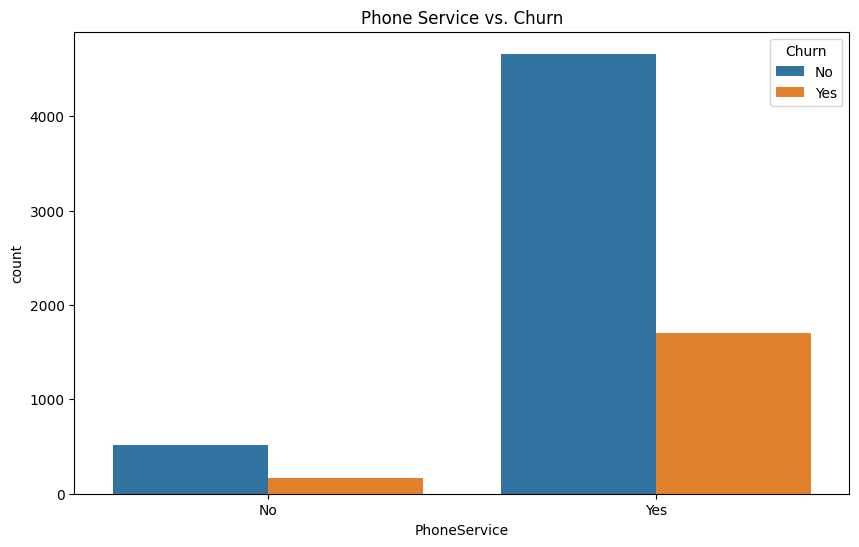

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='PhoneService', hue='Churn', data=df)
plt.title('Phone Service vs. Churn')
plt.show()

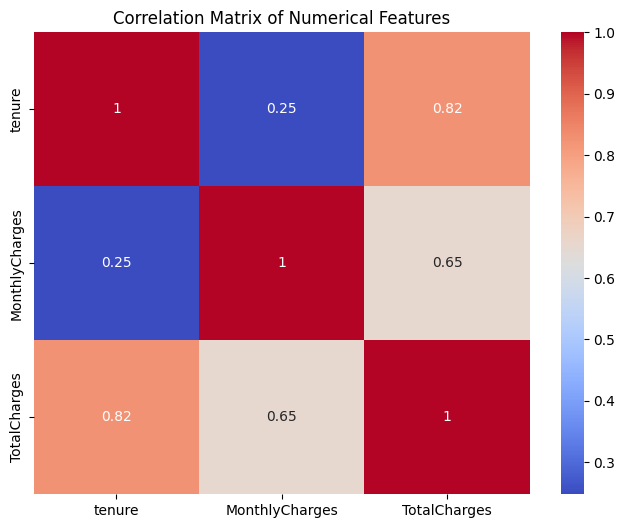

In [22]:
# Correlation matrix (numerical features)
plt.figure(figsize=(8,6))
sns.heatmap(df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

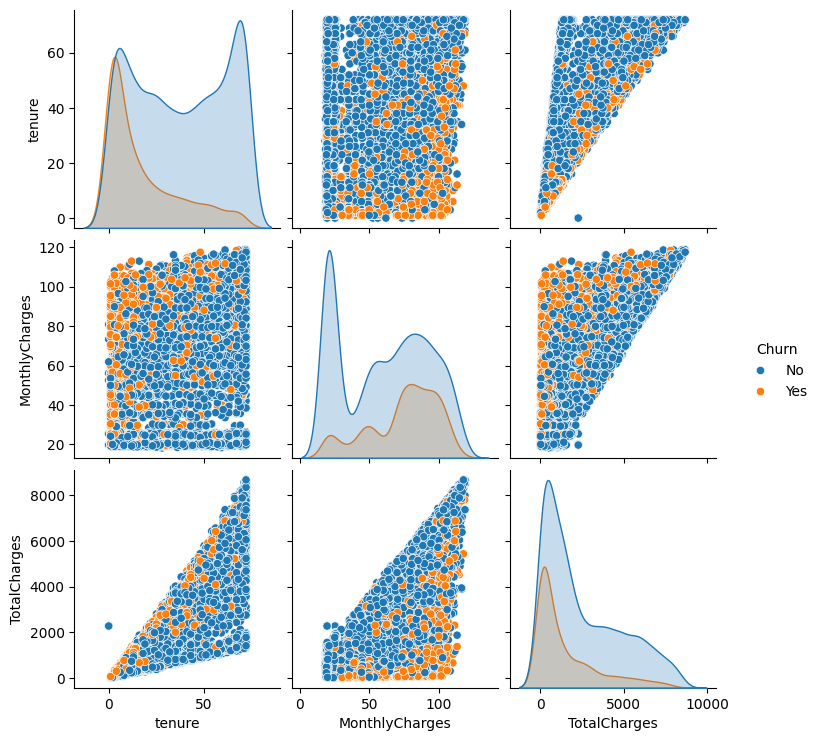

In [23]:
sns.pairplot(df, hue = 'Churn')
plt.show()

## Feature Engineering

In [24]:
# Encoding categorical features using one-hot encoding
categorical_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
                    'PaymentMethod']

# Check for typos and case sensitivity
# Print the available columns in your DataFrame
print(df.columns)

# Correct any typos or case mismatches in categorical_cols based on the output above

# Filter categorical_cols to only include columns present in the DataFrame
categorical_cols = [col for col in categorical_cols if col in df.columns]

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) #drop_first to avoid multicollinearity

Index(['tenure', 'PhoneService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [25]:
df.select_dtypes(exclude='number').columns

Index(['Churn', 'PhoneService_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [26]:
df.select_dtypes(exclude='number')

,Churn,PhoneService_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,
7590-VHVEG,No,False,False,False,True,False,True,False
5575-GNVDE,No,True,True,False,False,False,False,True
3668-QPYBK,Yes,True,False,False,True,False,False,True
7795-CFOCW,No,False,True,False,False,False,False,False
9237-HQITU,Yes,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...
6840-RESVB,No,True,True,False,True,False,False,True
2234-XADUH,No,True,True,False,True,True,False,False
4801-JZAZL,No,False,False,False,True,False,True,False


In [27]:
# Feature selection (example using SelectKBest)
from sklearn.feature_selection import SelectKBest, f_classif

X = df.drop(columns=['Churn'])
y = df['Churn']

selector = SelectKBest(score_func=f_classif, k=20)  # Select top 20 features
X_new = selector.fit_transform(X, y)

# Convert the selected features back into a DataFrame (optional, for better readability)
selected_feature_indices = selector.get_support(indices=True)
selected_features = list(X.columns[selected_feature_indices])
X_new = pd.DataFrame(X_new, columns=selected_features)


print(X_new.head())

   tenure  MonthlyCharges  TotalCharges  PhoneService_Yes  Contract_One year  \
0     1.0           29.85         29.85               0.0                0.0   
1    34.0           56.95       1889.50               1.0                1.0   
2     2.0           53.85        108.15               1.0                0.0   
3    45.0           42.30       1840.75               0.0                1.0   
4     2.0           70.70        151.65               1.0                0.0   

   Contract_Two year  PaperlessBilling_Yes  \
0                0.0                   1.0   
1                0.0                   0.0   
2                0.0                   1.0   
3                0.0                   0.0   
4                0.0                   1.0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                    0.0                             1.0   
1                                    0.0                             0.0   
2             

In [28]:
X_new.index = df.index

In [29]:
X_new

,tenure,MonthlyCharges,TotalCharges,PhoneService_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,
7590-VHVEG,1.0,29.85,29.85,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5575-GNVDE,34.0,56.95,1889.50,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3668-QPYBK,2.0,53.85,108.15,1.0,0.0,0.0,1.0,0.0,0.0,1.0
7795-CFOCW,45.0,42.30,1840.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9237-HQITU,2.0,70.70,151.65,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,24.0,84.80,1990.50,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2234-XADUH,72.0,103.20,7362.90,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4801-JZAZL,11.0,29.60,346.45,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [30]:
df1 = pd.concat([X_new, y], axis=1)

In [31]:
# prompt: convert churn column into binary column

# Convert 'Churn' column to binary (0 and 1)
df1['Churn'] = df1['Churn'].map({'No': 0, 'Yes': 1})

In [32]:
df1

,tenure,MonthlyCharges,TotalCharges,PhoneService_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
customerID,,,,,,,,,,,
7590-VHVEG,1.0,29.85,29.85,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
5575-GNVDE,34.0,56.95,1889.50,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0
3668-QPYBK,2.0,53.85,108.15,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
7795-CFOCW,45.0,42.30,1840.75,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
9237-HQITU,2.0,70.70,151.65,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,24.0,84.80,1990.50,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
2234-XADUH,72.0,103.20,7362.90,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
4801-JZAZL,11.0,29.60,346.45,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0


In [ ]:
# !pip install pycaret

In [34]:
# prompt: using pycaret create machine learning model.



from pycaret.classification import *

# Assuming df1 is your preprocessed DataFrame with 'Churn' as the target variable
# and other features.  Replace this with your actual DataFrame.

# Initialize the setup
clf = setup(data = df1, target = 'Churn', session_id = 123)

# Compare models
best_model = compare_models()

# Tune the best model (optional)
tuned_best_model = tune_model(best_model)

# Evaluate the tuned model
evaluate_model(tuned_best_model)

# Predict on new data (replace 'new_data' with your new dataset)
# predictions = predict_model(tuned_best_model, data = new_data)

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(7043, 11)"
4,Transformed data shape,"(7043, 11)"
5,Transformed train set shape,"(4930, 11)"
6,Transformed test set shape,"(2113, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7970,0.8380,0.5069,0.6514,0.5683,0.4387,0.4456,0.7370
lr,Logistic Regression,0.7963,0.8362,0.5237,0.6436,0.5770,0.4448,0.4492,0.7820
ridge,Ridge Classifier,0.7937,0.8266,0.4748,0.6540,0.5493,0.4201,0.4296,0.0400
ada,Ada Boost Classifier,0.7907,0.8385,0.5161,0.6292,0.5661,0.4302,0.4344,0.2840
lda,Linear Discriminant Analysis,0.7905,0.8267,0.5283,0.6251,0.5720,0.4347,0.4378,0.0390
lightgbm,Light Gradient Boosting Machine,0.7862,0.8270,0.5146,0.6171,0.5597,0.4205,0.4243,0.4290
xgboost,Extreme Gradient Boosting,0.7805,0.8168,0.5153,0.6016,0.5543,0.4101,0.4127,0.2280
rf,Random Forest Classifier,0.7669,0.7993,0.4710,0.5743,0.5170,0.3656,0.3689,0.6010
knn,K Neighbors Classifier,0.7645,0.7467,0.4412,0.5726,0.4978,0.3476,0.3529,0.1270
et,Extra Trees Classifier,0.7519,0.7681,0.4740,0.5364,0.5028,0.3386,0.3400,0.7840


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8215,0.8536,0.4692,0.7625,0.5810,0.4756,0.4982
1,0.7972,0.8291,0.3923,0.7083,0.5050,0.3903,0.4173
2,0.7850,0.8247,0.3359,0.6984,0.4536,0.3396,0.3749
3,0.7870,0.8309,0.3740,0.6806,0.4828,0.3626,0.3884
4,0.7809,0.8249,0.3969,0.6420,0.4906,0.3608,0.3777
5,0.7972,0.8282,0.3969,0.7123,0.5098,0.3947,0.4215
6,0.7870,0.8465,0.3435,0.7031,0.4615,0.3478,0.3825
7,0.7931,0.8432,0.3435,0.7377,0.4688,0.3608,0.4015
8,0.8114,0.8645,0.4809,0.7159,0.5753,0.4600,0.4751


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [35]:
# Finalize the best model
final_gbc = finalize_model(tuned_best_model)

In [ ]:
# Save the model
# save_model(final_gbc, 'final_gbc_model')

In [ ]:
df_internet = pd.read_csv("internet_data.csv")

In [39]:
df_internet = pd.read_csv("internet_data.csv")

In [43]:
df_internet.columns

Index(['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies'],
      dtype='object')

In [44]:
df_internet.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


<font color=red size=5> Target Variable Data Imbalance</font>

In [46]:
# prompt: train test split of df1

from sklearn.model_selection import train_test_split

# Assuming df1 is your DataFrame and 'Churn' is your target variable
X = df1.drop('Churn', axis=1)
y = df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Adjust test_size and random_state as needed

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(5634, 10) (1409, 10) (5634,) (1409,)


In [47]:
# prompt: standard scaling of train and test dataset

from sklearn.preprocessing import StandardScaler

# Assuming X_train and X_test are your training and testing feature dataframes
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert the scaled data back to DataFrames (optional but recommended)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [ ]:
X_train.head(2)

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,aon,total_rech_amt_avg,vbc_3g_8,vbc_3g_7,vbc_3g_6
4715,-0.618756,-0.252174,-0.318969,0.078632,0.522991,0.303439,-0.569002,-0.729615,-0.625963,-0.238263,...,-0.593549,-0.115844,-0.138633,-0.781454,-0.039624,-0.938635,-0.520352,-0.329669,-0.330304,-0.310692
15222,-0.646107,-0.187018,-0.120157,-0.412727,-0.578274,-0.309775,-0.428518,-0.634190,-0.456984,-0.238263,...,0.280608,-0.649756,-0.274319,-0.496344,-0.791985,-0.198224,-0.514834,0.104407,-0.168340,-0.185233


In [49]:
print(y_train.mean())
print(y_test.mean())

0.2655307064252751
0.26472675656493966


### PCA Compression

In [50]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver="randomized",random_state=100)
pca_scaled = pca.fit_transform(X,y)
pca_scaled = pd.DataFrame(pca_scaled, index=X.index)
pca_scaled.head()

,0,1,2,3,4,5,6,7,8,9
customerID,,,,,,,,,,
7590-VHVEG,-2253.858422,-8.900794,16.867363,-1.138696,-0.152229,0.375669,-0.183043,0.668530,0.160301,-0.027377
5575-GNVDE,-393.822983,-6.235509,-2.665462,0.598833,0.594526,-0.923258,0.341410,-0.030260,0.098950,-0.201365
3668-QPYBK,-2175.348174,11.890574,6.331086,0.323847,-0.023533,0.179716,0.801312,-0.045180,-0.086498,-0.086680
7795-CFOCW,-442.597403,-24.046157,-6.666246,-0.043105,0.723508,-0.596168,-0.274209,0.831375,0.249336,0.378086
9237-HQITU,-2131.705892,26.858066,-0.595215,-0.536938,-0.167096,0.150126,-0.047217,-0.136102,0.091788,-0.044618


In [51]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#Only 1 PCA feature can explain 99.99% of variance

array([ 99.99, 100.  , 100.  , 100.  , 100.  , 100.  , 100.  , 100.  ,
       100.  , 100.  ])

In [52]:
# prompt: df_pca with only 3 features

# Assuming pca_scaled is the DataFrame from the previous PCA transformation
df_pca = pca_scaled.iloc[:, :3]  # Select the first 3 principal components
print(df_pca.head())

                      0          1          2
customerID                                   
7590-VHVEG -2253.858422  -8.900794  16.867363
5575-GNVDE  -393.822983  -6.235509  -2.665462
3668-QPYBK -2175.348174  11.890574   6.331086
7795-CFOCW  -442.597403 -24.046157  -6.666246
9237-HQITU -2131.705892  26.858066  -0.595215


In [54]:
df_pca.columns = ['PCA1','PCA2','PCA3']

In [57]:
# prompt: df_pca is dataframe, y is series combine them and create a dataframe df_pca1

df_pca1 = pd.concat([df_pca, y], axis=1)
print(df_pca1.head())

                   PCA1       PCA2       PCA3  Churn
customerID                                          
7590-VHVEG -2253.858422  -8.900794  16.867363      0
5575-GNVDE  -393.822983  -6.235509  -2.665462      0
3668-QPYBK -2175.348174  11.890574   6.331086      1
7795-CFOCW  -442.597403 -24.046157  -6.666246      0
9237-HQITU -2131.705892  26.858066  -0.595215      1


In [59]:
target_

'churn'

In [61]:
# split X, y into train and test
X_pca = df_pca1[ ['PCA1','PCA2']]
y_pca = df_pca1[target_]

from sklearn.model_selection import train_test_split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca,
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

<font color=red size=5>__Start Modeling__</font>

<font color=red size=5>Common Function Used in Modeling</font>

In [62]:
def predict_with_prob(model,y_, X_):
    y_pred = model.predict_proba(X_)
    df_pred = pd.DataFrame({"act_churn": y_, "churn_prob":list(y_pred[:,1]) })

    numbers = [float(x)/10 for x in range(10)]
    for i in numbers:
        df_pred[i]= df_pred.churn_prob.map(lambda x: 1 if x > i else 0)
    return df_pred

In [63]:
def create_metrics_table(df_pred):
    df_cutoff = pd.DataFrame( columns = ['prob','accuracy','recall','specificity','precision'])
    from sklearn.metrics import confusion_matrix

    # TP = confusion[1,1] # true positive
    # TN = confusion[0,0] # true negatives
    # FP = confusion[0,1] # false positives
    # FN = confusion[1,0] # false negatives

    num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in num:
        cm1 = metrics.confusion_matrix(df_pred.act_churn, df_pred[i] )
        total1=sum(sum(cm1))
        accuracy = (cm1[0,0]+cm1[1,1])/total1

        specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
        recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
        precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])
        df_cutoff.loc[i] =[ i ,accuracy,recall,specificity,precision]
    return df_cutoff

In [64]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
def plot_roc(df_cutoff):
    plt.figure(figsize=(15,3))
    sns.lineplot(x="prob", y='accuracy', data=df_cutoff, color="red")
    sns.lineplot(x="prob", y='recall'  , data=df_cutoff, color="green")
    sns.lineplot(x="prob", y='specificity'   , data=df_cutoff, color="blue")
    sns.lineplot(x="prob", y='precision'   , data=df_cutoff, color="black")

    plt.legend(["Accuracy","Recall","specificity","precision"])
    plt.show()

In [65]:
def predict_score(model, y_act, X_, probability):

    y_pred = model.predict_proba(X_)
    df_pred = pd.DataFrame({"y_actual": y_act, "pred_prob":list(y_pred[:,1]) })
    df_pred["y_pred"] = df_pred["pred_prob"].apply(lambda x: 1 if x>probability else 0)

    cm1 = metrics.confusion_matrix(y_act, df_pred.y_pred )
    total1=sum(sum(cm1))

    accuracy = (cm1[0,0]+cm1[1,1])/total1
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    recall = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    precision = cm1[1,1]/(cm1[0,1]+cm1[1,1])

    print ("Accuracy:\t", accuracy )
    print ("Recall:  \t", recall )
    print ("Specificity:\t", specificity )
    print ("Precision:\t", precision )

    print ("Confusion Matrix:\n", metrics.confusion_matrix(y_act, df_pred.y_pred) )

In [66]:
# plotting model parameters against the metrics
def plot_gridSearch_para(df_grid, parameters, matrix):
    plt.figure(figsize=(15,15))
    i=1
    for parameter in parameters:
        plt.subplot(6,3,i)
        i+=1

        sns.lineplot(x=df_grid[parameter],
                     y=df_grid["mean_train_score"],
                     label="training accuracy")

        sns.lineplot(x= df_grid[parameter],
                 y= df_grid["mean_test_score"],
                 label="test accuracy")

        #plt.xlabel("max_features")
        plt.ylabel(matrix)
        plt.legend()
    plt.show()

<font color=red size=6>__Logistic Regression__</font>

<font color=red size=3>__Logistic Regression Using PCA Features__</font>

In [67]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(class_weight="balanced")
model_lr.fit(X_train_pca,y_train_pca)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.264300  1.000000     0.000000   0.264300
0.1   0.1  0.319270  0.996930     0.075820   0.279295
0.2   0.2  0.478093  0.966232     0.302730   0.332365
0.3   0.3  0.613996  0.903300     0.510063   0.398443
0.4   0.4  0.690061  0.787414     0.655087   0.450593
0.5   0.5  0.727586  0.712203     0.733113   0.489451
0.6   0.6  0.754970  0.613968     0.805624   0.531561
0.7   0.7  0.780730  0.503454     0.880342   0.601835
0.8   0.8  0.791886  0.363008     0.945961   0.707025
0.9   0.9  0.746247  0.056792     0.993934   0.770833


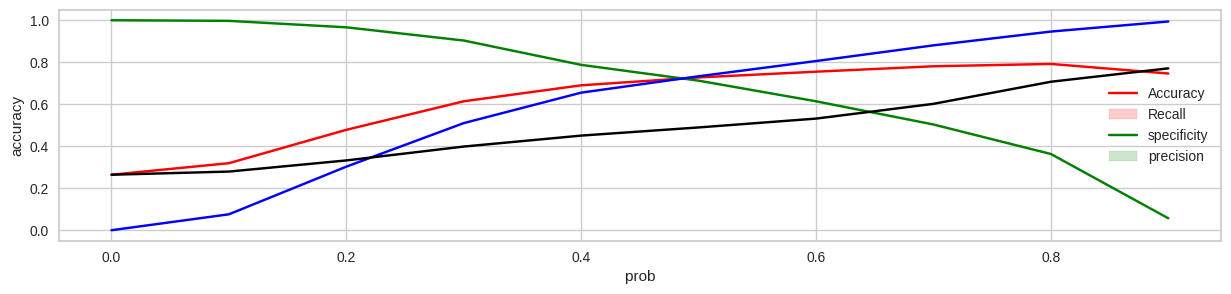

In [68]:
#Visualize the result on train data
df_pred=predict_with_prob(model_lr,y_train_pca,X_train_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.267866  1.000000     0.000000   0.267866
0.1   0.1  0.323237  0.998233     0.076277   0.283350
0.2   0.2  0.488405  0.968198     0.312864   0.340161
0.3   0.3  0.602461  0.899293     0.493859   0.393963
0.4   0.4  0.661619  0.780919     0.617970   0.427880
0.5   0.5  0.706105  0.713781     0.703297   0.468134
0.6   0.6  0.743493  0.616608     0.789916   0.517804
0.7   0.7  0.769995  0.482332     0.875242   0.585837
0.8   0.8  0.790345  0.369258     0.944409   0.708475
0.9   0.9  0.745859  0.074205     0.991597   0.763636


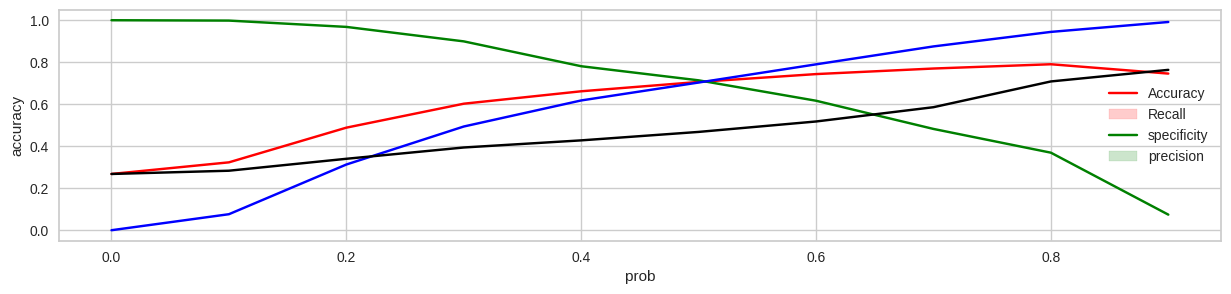

In [69]:
#Visualize the result on test data
df_pred=predict_with_prob(model_lr,y_test_pca,X_test_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [70]:
#Use optimum cutoff and see result on train data
predict_score(model_lr, y_train_pca, X_train_pca, .50)

Accuracy:	 0.7275862068965517
Recall:  	 0.7122026093630084
Specificity:	 0.7331127653708299
Precision:	 0.48945147679324896
Confusion Matrix:
 [[2659  968]
 [ 375  928]]


In [71]:
#Use optimum cutoff and see result on test data
predict_score(model_lr, y_test_pca, X_test_pca, .50)

Accuracy:	 0.7061050638902036
Recall:  	 0.7137809187279152
Specificity:	 0.7032967032967034
Precision:	 0.4681344148319815
Confusion Matrix:
 [[1088  459]
 [ 162  404]]


<font color=red size=3>__Logistic Regression Using Normal Features__</font>

In [72]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(class_weight="balanced")
model_lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.265531  1.000000     0.000000   0.265531
0.1   0.1  0.473908  0.985963     0.288787   0.333861
0.2   0.2  0.571885  0.964572     0.429918   0.379537
0.3   0.3  0.630813  0.925802     0.524166   0.412940
0.4   0.4  0.690983  0.866310     0.627598   0.456821
0.5   0.5  0.731097  0.796791     0.707347   0.496047
0.6   0.6  0.764821  0.711230     0.784195   0.543689
0.7   0.7  0.790025  0.570856     0.869261   0.612186
0.8   0.8  0.785233  0.336230     0.947559   0.698611
0.9   0.9  0.739972  0.024733     0.998550   0.860465


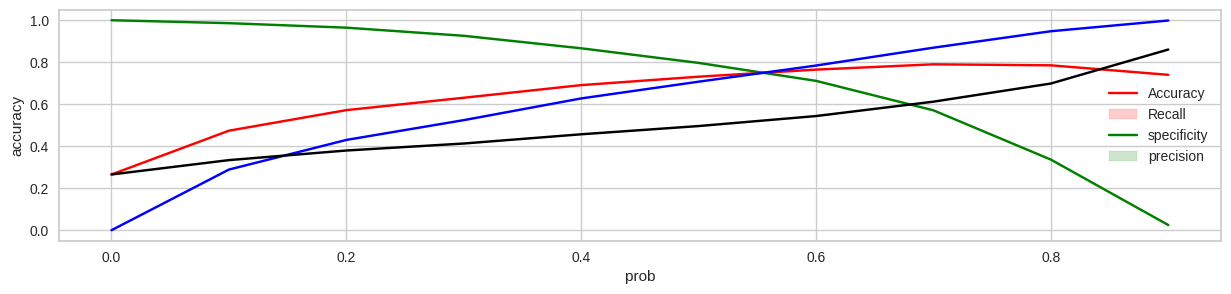

In [73]:
#Visualize the result on train data
df_pred=predict_with_prob(model_lr,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.264727  1.000000     0.000000   0.264727
0.1   0.1  0.486160  0.986595     0.305985   0.338546
0.2   0.2  0.576295  0.967828     0.435328   0.381607
0.3   0.3  0.635912  0.951743     0.522201   0.417647
0.4   0.4  0.701916  0.898123     0.631274   0.467225
0.5   0.5  0.738822  0.839142     0.702703   0.504026
0.6   0.6  0.779276  0.758713     0.786680   0.561508
0.7   0.7  0.807665  0.616622     0.876448   0.642458
0.8   0.8  0.799148  0.380697     0.949807   0.731959
0.9   0.9  0.739532  0.018767     0.999035   0.875000


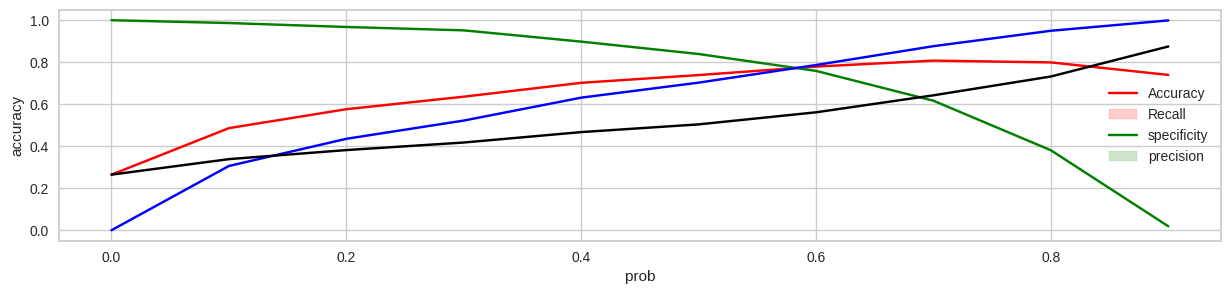

In [74]:
#Visualize the result on test data
df_pred=predict_with_prob(model_lr,y_test,X_test)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [75]:
#Use optimum cutoff and see result on train data
predict_score(model_lr, y_train, X_train, .50)

Accuracy:	 0.7310969116080938
Recall:  	 0.7967914438502673
Specificity:	 0.7073465442242629
Precision:	 0.496046608406159
Confusion Matrix:
 [[2927 1211]
 [ 304 1192]]


In [76]:
#Use optimum cutoff and see result on test data
predict_score(model_lr, y_test, X_test, .50)

Accuracy:	 0.7388218594748048
Recall:  	 0.839142091152815
Specificity:	 0.7027027027027027
Precision:	 0.5040257648953301
Confusion Matrix:
 [[728 308]
 [ 60 313]]


<font color=red size=5>__Modeling Using PCA__</font>

<font color=red size=5>__RandomForestClassfier Using PCA Features__</font>

In [77]:
from sklearn.ensemble import RandomForestClassifier
param_grid = {"max_depth" : [2, 5],
              "n_estimators": [100, 200, 400],
              "max_features": [2],
              "min_samples_leaf": [50],
              "min_samples_split":[50]
              }

model_rfc_pca = RandomForestClassifier(random_state=100, class_weight="balanced")

folds = 3
grid_search_rfc_pca = GridSearchCV(model_rfc_pca,
                               cv = folds,
                               param_grid=param_grid,
                               scoring = 'roc_auc',
                               return_train_score=True,
                               verbose = 1)

grid_search_rfc_pca.fit(X_train_pca,  y_train_pca)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              monotonic_cst=None,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                              verbose=0, warm_start=False),
             n_jobs=None,
             param_grid={'max_depth': [2, 5], 'max_features': [2],
                         'min_samples_leaf': [50], 'min_samples_split': [50],
                         'n_estimators': [100, 200, 400]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [78]:
df_scores = pd.DataFrame( grid_search_rfc_pca.cv_results_)
df_scores.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.328159,0.016625,0.012539,0.000155,2,2,50,50,100,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",...,0.795125,0.806057,0.806401,0.009350,6,0.812655,0.814732,0.815590,0.814326,0.001232
1,0.643436,0.005392,0.021527,0.001567,2,2,50,50,200,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",...,0.795572,0.808400,0.806655,0.008427,5,0.811912,0.814140,0.816780,0.814277,0.001990
2,1.624680,0.254317,0.040726,0.004843,2,2,50,50,400,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",...,0.795904,0.807972,0.807054,0.008753,4,0.813206,0.814489,0.816175,0.814623,0.001216
3,0.488033,0.006587,0.017780,0.001000,5,2,50,50,100,"{'max_depth': 5, 'max_features': 2, 'min_sampl...",...,0.812802,0.820087,0.820625,0.006618,2,0.837083,0.843418,0.842136,0.840879,0.002735
4,0.949021,0.006488,0.031027,0.000585,5,2,50,50,200,"{'max_depth': 5, 'max_features': 2, 'min_sampl...",...,0.812736,0.820364,0.820707,0.006653,1,0.837403,0.843230,0.841973,0.840869,0.002504


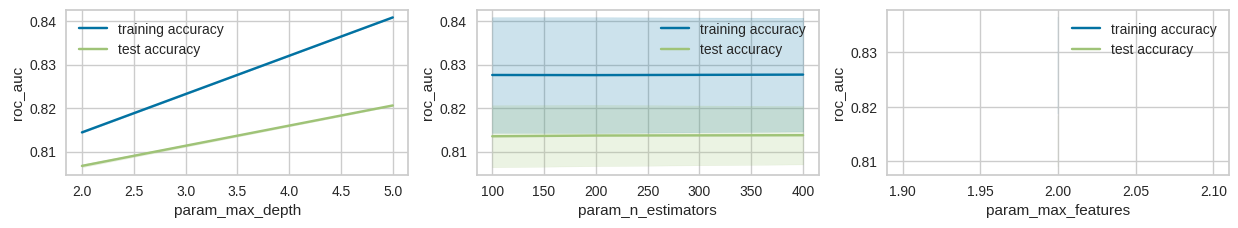

In [79]:
#para_list=["param_max_depth","param_n_estimators","param_max_features","param_min_samples_leaf","param_min_sample_split"]
para_list=["param_max_depth","param_n_estimators","param_max_features"]
plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising RandomForestClassier PCA Model Parameters__</font>

In [80]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_pca1 = RandomForestClassifier(max_depth=5,
                                        n_estimators=100,
                                        max_features=2,
                                        min_samples_leaf=50,
                                        min_samples_split=50,
                                        random_state=100, class_weight="balanced")

model_rfc_pca1.fit(X_train_pca, y_train_pca)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=50,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

<font color=red size=3>__Evaluating RandomForestClassifer PCA Model__</font>

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.264300  1.000000     0.000000   0.264300
0.1   0.1  0.390264  0.993860     0.173422   0.301654
0.2   0.2  0.563083  0.954720     0.422388   0.372567
0.3   0.3  0.637525  0.907905     0.540392   0.415088
0.4   0.4  0.686410  0.863392     0.622829   0.451264
0.5   0.5  0.774037  0.706063     0.798456   0.557238
0.6   0.6  0.791075  0.640829     0.845051   0.597709
0.7   0.7  0.802231  0.544129     0.894955   0.650459
0.8   0.8  0.791886  0.316193     0.962779   0.753199
0.9   0.9  0.769168  0.155027     0.989799   0.845188


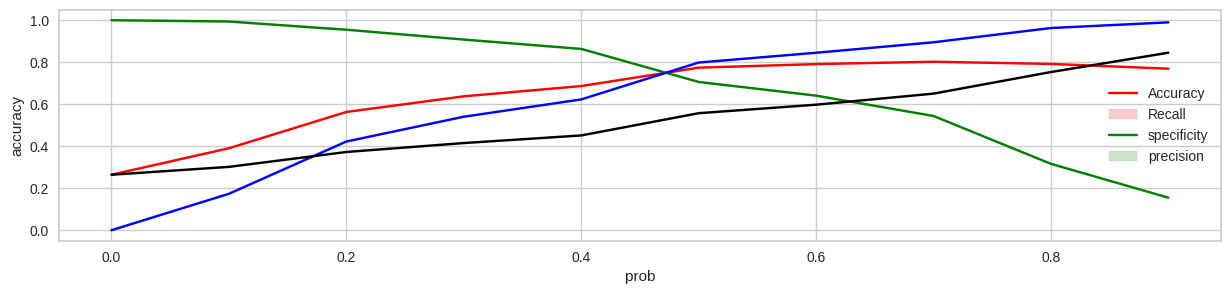

In [81]:
#Evaluate on Train Data
df_pred=predict_with_prob(model_rfc_pca1,y_train_pca,X_train_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [82]:
#Use optimum cutoff and see result on train data
predict_score(model_rfc_pca1, y_train_pca, X_train_pca, .45)

Accuracy:	 0.7137931034482758
Recall:  	 0.8204144282425173
Specificity:	 0.6754893851668046
Precision:	 0.4759572573463936
Confusion Matrix:
 [[2450 1177]
 [ 234 1069]]


     prob  accuracy    recall  specificity  precision
0.0   0.0  0.267866  1.000000     0.000000   0.267866
0.1   0.1  0.396119  0.994700     0.177117   0.306645
0.2   0.2  0.548982  0.946996     0.403361   0.367375
0.3   0.3  0.622338  0.893993     0.522948   0.406752
0.4   0.4  0.669191  0.840989     0.606335   0.438710
0.5   0.5  0.753904  0.696113     0.775048   0.530997
0.6   0.6  0.767156  0.614841     0.822883   0.559486
0.7   0.7  0.775674  0.526502     0.866839   0.591270
0.8   0.8  0.785613  0.325088     0.954105   0.721569
0.9   0.9  0.761950  0.160777     0.981900   0.764706


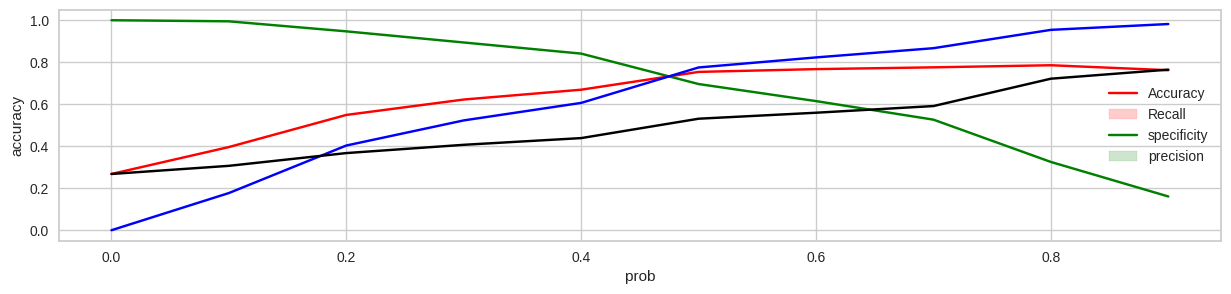

In [83]:
#Evaluate on Test Data
df_pred=predict_with_prob(model_rfc_pca1,y_test_pca,X_test_pca)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [84]:
#Use optimum cutoff and see result on test data
predict_score(model_rfc_pca1, y_test_pca, X_test_pca, .45)

Accuracy:	 0.6914339801230478
Recall:  	 0.8003533568904594
Specificity:	 0.6515837104072398
Precision:	 0.4566532258064516
Confusion Matrix:
 [[1008  539]
 [ 113  453]]


### RandomForestClassifer using Normal Features

In [85]:
param_grid = {"max_depth" : range(2, 20, 5),
              "n_estimators": [100, 200, 400],
              "max_features": [10,15,20,25],
              "min_samples_leaf": [25,50,100,150,200],
              "min_samples_split":[25,50,100,150,200]
              }

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_nor= RandomForestClassifier(class_weight="balanced", random_state=100)

folds = 3
grid_search_rfc_nor = GridSearchCV(model_rfc_nor,
                               cv = folds,
                               param_grid=param_grid,
                               scoring = 'roc_auc',
                               return_train_score=True,
                               verbose = 1)

grid_search_rfc_nor.fit(X_train,  y_train)

<font color=red size=3>__Evaluating RandomForestClassifer Model__</font>

In [ ]:
df_scores = pd.DataFrame( grid_search_rfc_nor.cv_results_)
df_scores.head(5)

In [ ]:
para_list=["param_max_depth","param_n_estimators","param_max_features","param_min_samples_leaf","param_min_samples_split"]

plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising RandomForestClassier Model Parameters__</font>

In [87]:
from sklearn.ensemble import RandomForestClassifier

model_rfc_nor1= RandomForestClassifier(max_depth=7,n_estimators=100,
                                       max_features=10,min_samples_leaf=50,
                                       min_samples_split=50,class_weight="balanced", random_state=100)

model_rfc_nor1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=50,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=100, verbose=0,
                       warm_start=False)

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.266418  1.000000     0.001208   0.265767
0.1   0.1  0.504260  0.989973     0.328661   0.347734
0.2   0.2  0.577920  0.977273     0.433543   0.384130
0.3   0.3  0.651225  0.939840     0.546883   0.428528
0.4   0.4  0.717430  0.876337     0.659981   0.482340
0.5   0.5  0.754526  0.822193     0.730063   0.524073
0.6   0.6  0.792510  0.704545     0.824311   0.591802
0.7   0.7  0.805112  0.557487     0.894635   0.656693
0.8   0.8  0.791800  0.324198     0.960851   0.749614
0.9   0.9  0.762691  0.125668     0.992992   0.866359


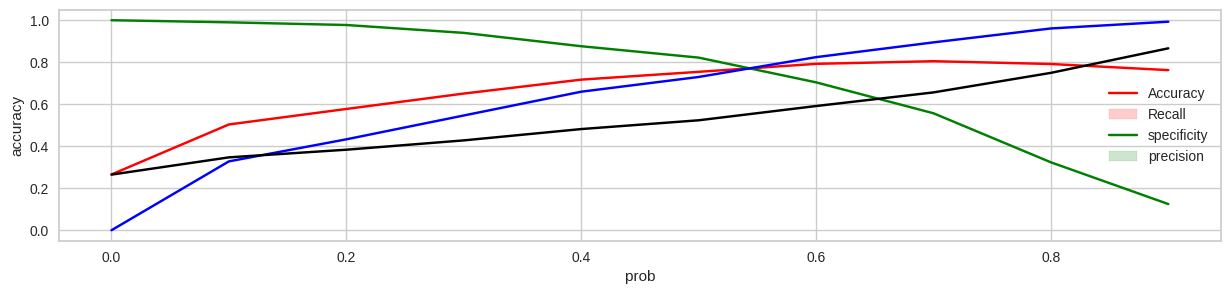

In [88]:
df_pred=predict_with_prob(model_rfc_nor1,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [89]:
predict_score(model_rfc_nor1, y_train, X_train, .40)

Accuracy:	 0.7174298899538516
Recall:  	 0.8763368983957219
Specificity:	 0.6599806669888835
Precision:	 0.48233995584988965
Confusion Matrix:
 [[2731 1407]
 [ 185 1311]]


In [90]:
predict_score(model_rfc_nor1, y_train, X_train, .40)

Accuracy:	 0.7174298899538516
Recall:  	 0.8763368983957219
Specificity:	 0.6599806669888835
Precision:	 0.48233995584988965
Confusion Matrix:
 [[2731 1407]
 [ 185 1311]]


In [91]:
predict_score(model_rfc_nor1, y_test, X_test, .40)

Accuracy:	 0.7068843151171044
Recall:  	 0.8793565683646113
Specificity:	 0.6447876447876448
Precision:	 0.47126436781609193
Confusion Matrix:
 [[668 368]
 [ 45 328]]


<font color=red size=5>__DecisionTree using Normal Features__</font>

In [92]:
from sklearn.tree import DecisionTreeClassifier
param_grid = {"max_depth" : [2, 5],
              "max_features": [10,15,20,25],
              "min_samples_leaf": [50],
              "min_samples_split":[50]
              }
model_dt_nor = DecisionTreeClassifier(class_weight="balanced", random_state=100)

folds = 3
grid_search_dt_nor = GridSearchCV(model_dt_nor,
                               cv = folds,
                               param_grid=param_grid,
                               scoring = 'roc_auc',
                               return_train_score=True,
                               verbose = 1)

grid_search_dt_nor.fit(X_train,  y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              monotonic_cst=None,
                                              random_state=100,
                                              splitter='best'),
             n_jobs=None,
             param_grid={'max_depth': [2, 5], 'max_features': [10, 15, 20, 25],
                         'min_samples_leaf': [50], 'min_samples_split': [50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

<font color=red size=3>__Evaluating DecisionTree Model__</font>

In [93]:
df_scores = pd.DataFrame( grid_search_dt_nor.cv_results_)
df_scores.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.014270,0.002858,0.006965,0.000169,2,10,50,50,"{'max_depth': 2, 'max_features': 10, 'min_samp...",0.741518,0.738768,0.738433,0.739573,0.001382,5,0.738580,0.739887,0.740122,0.73953,0.000678
1,0.012818,0.001570,0.006320,0.000189,2,15,50,50,"{'max_depth': 2, 'max_features': 15, 'min_samp...",0.741518,0.738768,0.738433,0.739573,0.001382,5,0.738580,0.739887,0.740122,0.73953,0.000678
2,0.016844,0.006000,0.007881,0.002294,2,20,50,50,"{'max_depth': 2, 'max_features': 20, 'min_samp...",0.741518,0.738768,0.738433,0.739573,0.001382,5,0.738580,0.739887,0.740122,0.73953,0.000678
3,0.013916,0.002937,0.007773,0.002251,2,25,50,50,"{'max_depth': 2, 'max_features': 25, 'min_samp...",0.741518,0.738768,0.738433,0.739573,0.001382,5,0.738580,0.739887,0.740122,0.73953,0.000678
4,0.017923,0.002240,0.006269,0.000119,5,10,50,50,"{'max_depth': 5, 'max_features': 10, 'min_samp...",0.827804,0.812622,0.827360,0.822596,0.007054,1,0.837203,0.838677,0.838150,0.83801,0.000610


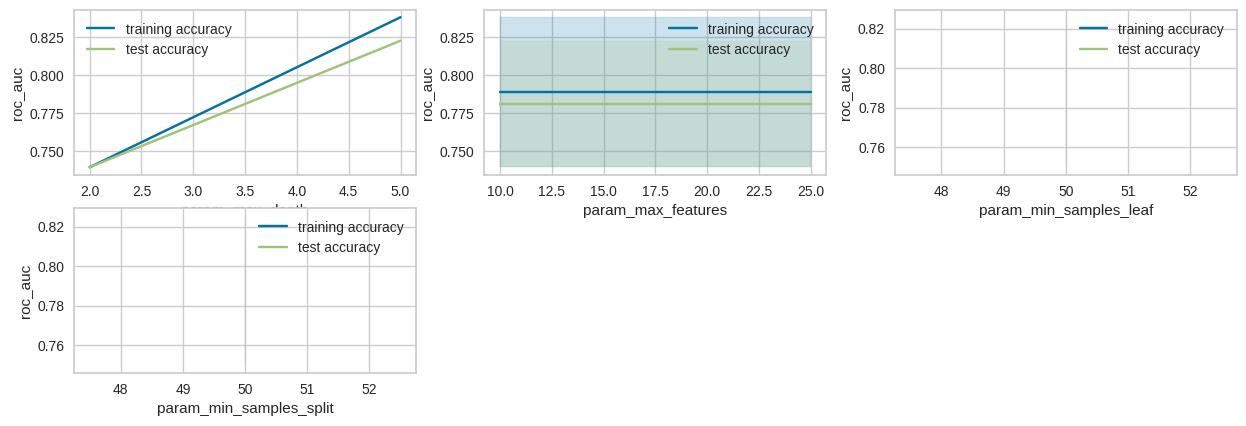

In [94]:
para_list=["param_max_depth","param_max_features","param_min_samples_leaf","param_min_samples_split"]

plot_gridSearch_para(df_scores, para_list, "roc_auc")

<font color=red size=3>__Optimising DecisionTree Model Parameters__</font>

In [95]:
model_dt_nor1 = DecisionTreeClassifier(max_depth=5, max_features=10,
                                      min_samples_leaf=50, min_samples_split=50)
model_dt_nor1.fit(X_train.values.tolist(), y_train.values.tolist())

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=50,
                       min_samples_split=50, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=None, splitter='best')

     prob  accuracy    recall  specificity  precision
0.0   0.0  0.314519  1.000000     0.066699   0.279209
0.1   0.1  0.591232  0.947861     0.462301   0.389240
0.2   0.2  0.704650  0.854947     0.650314   0.469186
0.3   0.3  0.747781  0.786096     0.733929   0.516469
0.4   0.4  0.769968  0.697861     0.796037   0.552966
0.5   0.5  0.793752  0.368984     0.947318   0.716883
0.6   0.6  0.793752  0.368984     0.947318   0.716883
0.7   0.7  0.780263  0.240642     0.975350   0.779221
0.8   0.8  0.752929  0.078209     0.996858   0.900000
0.9   0.9  0.746006  0.048128     0.998308   0.911392


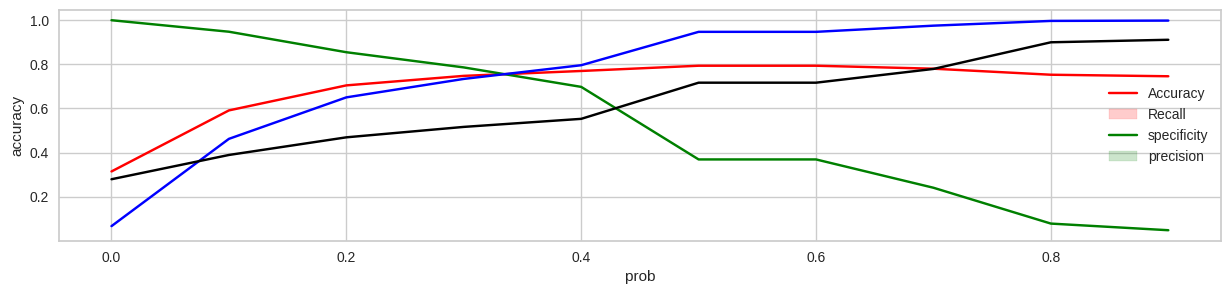

In [96]:
df_pred=predict_with_prob(model_dt_nor1,y_train,X_train)
#print (df_pred)
df_cutoff = create_metrics_table(df_pred)
print (df_cutoff)

plot_roc(df_cutoff)

In [97]:
predict_score(model_dt_nor1, y_train, X_train, .04)

Accuracy:	 0.4913028044018459
Recall:  	 0.9893048128342246
Specificity:	 0.3112614789753504
Precision:	 0.3418013856812933
Confusion Matrix:
 [[1288 2850]
 [  16 1480]]


In [98]:
predict_score(model_dt_nor1, y_test, X_test, .04)

Accuracy:	 0.47764371894960966
Recall:  	 0.9785522788203753
Specificity:	 0.2972972972972973
Precision:	 0.33394327538883806
Confusion Matrix:
 [[308 728]
 [  8 365]]


<font color=red size=6>__Check the Feature Importance__</font>

In [100]:
df_features = pd.DataFrame({"feature":X_train.columns, "coef":model_rfc_nor1.feature_importances_})
df_features.sort_values("coef", ascending=False)

,feature,coef
5,Contract_Two year,0.370499
4,Contract_One year,0.222182
1,MonthlyCharges,0.182007
0,tenure,0.129568
2,TotalCharges,0.046244
8,PaymentMethod_Electronic check,0.026336
3,PhoneService_Yes,0.013804
6,PaperlessBilling_Yes,0.007563
9,PaymentMethod_Mailed check,0.001194
7,PaymentMethod_Credit card (automatic),0.000602
